Training and comparing results of PHSI, SINDy, BSI and PHNN models on damped mass spring system with external forces.  

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
#import from phlearn
from phlearn.phnns import PseudoHamiltonianNN
from phlearn.phnns import R_estimator, HamiltonianNN, ExternalForcesNN
from phlearn.phnns import npoints_to_ntrajectories_tsample

#import from phsi
from phsi.phsystems import init_msdsystem
from phsi.phnns import PHSI, ExternalForcesSI, BaselineSI, generate_dataset, train
ttype = torch.float32
torch.set_default_dtype(ttype)

In [3]:
#set up parameters
ntrainingpoints = 5000
sampling_time = 1/10
t_max = 10
integrator = 'srk4'
F_timedependent = True
F_statedependent = False
hidden_dim = 100
learning_rate = 5e-3
batch_size = 32
epochs = 150
l1_param_forces = 0.01
l1_param_dissipation = 0.
l1_val_params = 0.1
pruning_interval = 20
shuffle = True
noise_std = 0.
seed = 1
verbose = True
ntrajectories_val = 0

In [4]:
#set up mass spring system
ntrajectories_train, t_sample = npoints_to_ntrajectories_tsample(ntrainingpoints, t_max, sampling_time)

pH_system = init_msdsystem()
pH_system.seed(seed=seed)
damped_states = [False, True]

nstates = pH_system.nstates

In [5]:
#generate data
traindata = generate_dataset(pH_system, integrator, ntrajectories_train, t_sample, nsamples=ntrainingpoints, noise_std=noise_std)
valdata = generate_dataset(pH_system, integrator, ntrajectories_val, t_sample, noise_std=noise_std)

#generate noisy data
noise_std = 0.2
traindata_noise = generate_dataset(pH_system, integrator, ntrajectories_train, t_sample, nsamples=ntrainingpoints, noise_std=noise_std)
valdata_noise = generate_dataset(pH_system, integrator, ntrajectories_val, t_sample, noise_std=noise_std)   

In [6]:
#set up PHSI model
function_space_ext = np.array([1,1])
external_forces_filter = np.zeros(nstates)
external_forces_filter[-1] = 1
ext_forces_si = ExternalForcesSI(nstates, F_timedependent, F_statedependent, \
                                function_space_ext, degrees=3)
ext_forces_si_noise = ExternalForcesSI(nstates, F_timedependent, F_statedependent, \
                                function_space_ext, degrees=3)

r_estimator = R_estimator(damped_states)
r_estimator_noise = R_estimator(damped_states)
function_space = np.array([1,0])
model_phsi=PHSI(nstates, pH_system.structure_matrix, function_space, \
                ext_forces_si, r_estimator, degrees=3, full_si=True)
model_phsi_noise=PHSI(nstates, pH_system.structure_matrix, function_space, \
                ext_forces_si_noise, r_estimator_noise, degrees=3, full_si=True)

optimizer_phsi = torch.optim.Adam(model_phsi.parameters(), lr=learning_rate, weight_decay=1e-4)
optimizer_phsi_noise = torch.optim.Adam(model_phsi_noise.parameters(), lr=learning_rate, weight_decay=1e-4)

In [7]:
#train PHSI model
phsi, vloss_phsi = train(model_phsi, integrator, traindata, optimizer_phsi, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces,
                  l1_param_dissipation=l1_param_dissipation, l1_val_params=l1_val_params, prune_val=pruning_interval,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)

/Users/Sigurd/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



Epoch 0
Training loss: 2.97e+04
Epoch training time: 3.79 seconds
x^[1 0]: 0.7542, x^[2 0]:-0.2617, x^[3 0]: 0.7252, x^[2 1]: 0.9722, x^[1 1]:-0.5869, 
x^[1 2]: 0.6457, x^[0 1]: 0.8496, x^[0 2]:-0.4201, x^[0 3]: 0.1144, 

r1:  0.3312, 
Forces Parameters: 
x^[1]: 0.4528, x^[2]: 0.4647, x^[3]: 0.4767, cos(x_0): amp= 1.3975 freq= 1.1076, sin(x_0): amp= 1.1259 freq= 1.2600,


Epoch 1
Training loss: 4.69e+03
Epoch training time: 3.38 seconds
x^[1 0]: 1.0417, x^[2 0]:-0.7113, x^[3 0]: 0.9142, x^[2 1]: 1.2296, x^[1 1]:-1.0640, 
x^[1 2]: 0.7051, x^[0 1]: 1.2084, x^[0 2]:-0.8502, x^[0 3]: 0.1516, 

r1:  0.4157, 
Forces Parameters: 
x^[1]: 0.1229, x^[2]: 0.1230, x^[3]: 0.1315, cos(x_0): amp= 1.6360 freq= 1.0911, sin(x_0): amp= 1.3741 freq= 1.2303,


Epoch 2
Training loss: 4.21e+02
Epoch training time: 3.21 seconds
x^[1 0]: 1.0244, x^[2 0]:-0.9591, x^[3 0]: 0.7280, x^[2 1]: 1.0247, x^[1 1]:-1.2034, 
x^[1 2]: 0.7035, x^[0 1]: 1.0368, x^[0 2]:-0.8370, x^[0 3]: 0.1467, 

r1:  0.4090, 
Forces Parame

In [29]:
#train PHSI model on noisy data
phsi_noise, vloss_phsi = train(model_phsi_noise, integrator, traindata_noise, optimizer_phsi_noise, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces,
                  l1_param_dissipation=l1_param_dissipation, l1_val_params=l1_val_params, prune_val=pruning_interval,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)

/Users/Sigurd/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



Epoch 0
Training loss: 1.14e+01
Epoch training time: 3.80 seconds
x^[1 0]:-0.1848, x^[2 0]: 0.4230, x^[3 0]: 0.0329, x^[2 1]:-0.0290, x^[1 1]: 0.0373, 
x^[1 2]: 0.3312, x^[0 1]:-0.0289, x^[0 2]: 0.2500, x^[0 3]: 0.0075, 

r1:  0.2752, 
Forces Parameters: 
x^[1]: 0.3042, x^[2]: 0.0754, x^[3]:-0.0095, cos(x_0): amp= 1.4758 freq= 0.7996, sin(x_0): amp= 3.0703 freq= 0.5898,


Epoch 1
Training loss: 1.11e+01
Epoch training time: 3.46 seconds
x^[1 0]:-0.1228, x^[2 0]: 0.4220, x^[3 0]: 0.0238, x^[2 1]:-0.0203, x^[1 1]: 0.0448, 
x^[1 2]: 0.3112, x^[0 1]:-0.0006, x^[0 2]: 0.2628, x^[0 3]: 0.0052, 

r1:  0.2732, 
Forces Parameters: 
x^[1]: 0.2958, x^[2]: 0.0725, x^[3]:-0.0098, cos(x_0): amp= 1.4109 freq= 0.7949, sin(x_0): amp= 3.0288 freq= 0.5923,


Epoch 2
Training loss: 1.06e+01
Epoch training time: 3.61 seconds
x^[1 0]:-0.0633, x^[2 0]: 0.4208, x^[3 0]: 0.0251, x^[2 1]:-0.0192, x^[1 1]: 0.0379, 
x^[1 2]: 0.2907, x^[0 1]: 0.0005, x^[0 2]: 0.2771, x^[0 3]: 0.0032, 

r1:  0.2713, 
Forces Parame

In [9]:
#set up PHNN model
hamiltonian_nn = HamiltonianNN(nstates, hidden_dim)
ext_forces_nn = ExternalForcesNN(nstates, 1, hidden_dim=hidden_dim,
                                timedependent=F_timedependent,
                                statedependent=F_statedependent,
                                external_forces_filter=external_forces_filter)
ext_forces_nn_noise = ExternalForcesNN(nstates, 1, hidden_dim=hidden_dim,
                                timedependent=F_timedependent,
                                statedependent=F_statedependent,
                                external_forces_filter=external_forces_filter)

r_est = R_estimator(damped_states)
r_est_noise = R_estimator(damped_states)

model_phnn = PseudoHamiltonianNN(nstates,
                            pH_system.structure_matrix,
                            hamiltonian_est=hamiltonian_nn,
                            dissipation_est=r_est,
                            external_forces_est=ext_forces_nn)
model_phnn_noise = PseudoHamiltonianNN(nstates,
                            pH_system.structure_matrix,
                            hamiltonian_est=hamiltonian_nn,
                            dissipation_est=r_est_noise,
                            external_forces_est=ext_forces_nn_noise)

optimizer_phnn = torch.optim.Adam(model_phnn.parameters(), lr=learning_rate, weight_decay=1e-4)
optimizer_phnn_noise = torch.optim.Adam(model_phnn_noise.parameters(), lr=1e-3, weight_decay=1e-4)

In [26]:
#train PHNN model
phnn, vloss_phnn = train(model_phnn, integrator, traindata, optimizer_phnn, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces,
                  l1_param_dissipation=l1_param_dissipation, loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)


Epoch 0
Training loss: 2.75e-02
Epoch training time: 1.60 seconds

Epoch 1
Training loss: 6.82e-04
Epoch training time: 1.59 seconds

Epoch 2
Training loss: 5.73e-04
Epoch training time: 1.47 seconds

Epoch 3
Training loss: 5.57e-04
Epoch training time: 1.28 seconds

Epoch 4
Training loss: 5.19e-04
Epoch training time: 1.68 seconds

Epoch 5
Training loss: 5.69e-04
Epoch training time: 1.62 seconds

Epoch 6
Training loss: 4.95e-04
Epoch training time: 1.70 seconds

Epoch 7
Training loss: 5.41e-04
Epoch training time: 1.79 seconds

Epoch 8
Training loss: 5.47e-04
Epoch training time: 1.70 seconds

Epoch 9
Training loss: 5.77e-04
Epoch training time: 2.3 seconds

Epoch 10
Training loss: 5.49e-04
Epoch training time: 1.91 seconds

Epoch 11
Training loss: 5.52e-04
Epoch training time: 2.38 seconds

Epoch 12
Training loss: 5.33e-04
Epoch training time: 1.89 seconds

Epoch 13
Training loss: 6.43e-04
Epoch training time: 2.69 seconds

Epoch 14
Training loss: 5.75e-04
Epoch training time: 2.34

In [11]:
#train PHNN model on noisy data
phnn_noise, vloss_phnn = train(model_phnn_noise, integrator, traindata_noise, optimizer_phnn_noise, valdata=valdata_noise, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, l1_param_forces=l1_param_forces,
                  l1_param_dissipation=l1_param_dissipation, loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)


Epoch 0
Training loss: 8.31e+00
Epoch training time: 0.71 seconds

Epoch 1
Training loss: 8.13e+00
Epoch training time: 0.70 seconds

Epoch 2
Training loss: 8.16e+00
Epoch training time: 0.88 seconds

Epoch 3
Training loss: 8.08e+00
Epoch training time: 0.70 seconds

Epoch 4
Training loss: 8.1e+00
Epoch training time: 0.72 seconds

Epoch 5
Training loss: 8.07e+00
Epoch training time: 0.68 seconds

Epoch 6
Training loss: 8.09e+00
Epoch training time: 0.71 seconds

Epoch 7
Training loss: 8.08e+00
Epoch training time: 0.67 seconds

Epoch 8
Training loss: 8.06e+00
Epoch training time: 0.68 seconds

Epoch 9
Training loss: 8.05e+00
Epoch training time: 0.82 seconds


In [12]:
#set up BSI model
pol_space = True
trig_space = True
time_pol_space = True
time_trig_space = True
model_baseline = BaselineSI(nstates, degrees=3, pol_space=pol_space, trig_space=trig_space, time_pol_space=time_pol_space, time_trig_space=time_trig_space)
model_baseline_noise = BaselineSI(nstates, degrees=3, pol_space=pol_space, trig_space=trig_space, time_pol_space=time_pol_space, time_trig_space=time_trig_space)

optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=learning_rate, weight_decay=0)
optimizer_baseline_noise = torch.optim.Adam(model_baseline_noise.parameters(), lr=learning_rate, weight_decay=0)

In [14]:
#train BSI model
baselinesi, vloss = train(model_baseline, integrator, traindata, optimizer_baseline, valdata=valdata, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, prune_val=pruning_interval,
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)

/Users/Sigurd/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



Epoch 0
Training loss: 7.65e-01
Epoch training time: 1.50 seconds
x1': x^[0, 0]:-0.0490, x^[1 0]:-0.3862, x^[2 0]:-0.0491, x^[3 0]: 0.0294, 
x^[2 1]: 0.1034, x^[1 1]:-0.1086, x^[1 2]: 0.0560, x^[0 1]:-0.0095, x^[0 2]:-0.0006, 
x^[0 3]: 0.0703, 
cos(x_1): -0.1131, cos(x_2):  0.4784, sin(x_1):  0.2278, sin(x_2):  0.0179, 
t^1:-0.0227, t^2:-0.0052, t^3: 0.0006, 
cos(t): amp=  0.2412 freq=  0.4795, sin(t): amp= -0.0065 freq=  1.3772, 

x2': x^[0, 0]: 0.0978, x^[1 0]:-0.6690, x^[2 0]:-0.0222, x^[3 0]: 0.0025, 
x^[2 1]: 0.0780, x^[1 1]:-0.1092, x^[1 2]: 0.0206, x^[0 1]:-0.4372, x^[0 2]: 0.0477, 
x^[0 3]: 0.0099, 
cos(x_1):  0.0354, cos(x_2):  0.4722, sin(x_1):  0.1141, sin(x_2): -0.4504, 
t^1: 0.0331, t^2: 0.0106, t^3:-0.0027, 
cos(t): amp=  0.4848 freq=  0.4795, sin(t): amp=  0.0672 freq=  1.3772, 

Epoch 1
Training loss: 5.25e-01
Epoch training time: 1.34 seconds
x1': x^[0, 0]:-0.0421, x^[1 0]:-0.3864, x^[2 0]:-0.0459, x^[3 0]: 0.0264, 
x^[2 1]: 0.0899, x^[1 1]:-0.1102, x^[1 2]: 0.0467, x

In [25]:
#train BSI model on noisy data
baselinesi_noise, vloss = train(model_baseline_noise, integrator, traindata_noise, optimizer_baseline_noise, valdata=valdata_noise, epochs=epochs,
                  batch_size=batch_size, shuffle=shuffle, prune_val=pruning_interval, 
                  loss_fn=torch.nn.MSELoss(), verbose=verbose, return_best=True)

/Users/Sigurd/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



Epoch 0
Training loss: 8.11e+00
Epoch training time: 1.37 seconds
x1': x^[0 1]: 0.9987, 




x2': x^[0, 0]:-0.0200, x^[1 0]:-0.7840, x^[0 1]:-0.2575, 
cos(x_1):  0.1152, sin(x_1):  0.0000, 

cos(t): amp=  1.5761 freq=  0.2580, sin(t): amp= -0.3812 freq=  0.9981, 

Epoch 1
Training loss: 8.10e+00
Epoch training time: 1.33 seconds
x1': x^[0 1]: 1.0172, 




x2': x^[0, 0]:-0.0451, x^[1 0]:-0.7954, x^[0 1]:-0.2823, 
cos(x_1):  0.0954, sin(x_1):  0.0000, 

cos(t): amp=  1.5729 freq=  0.2596, sin(t): amp= -0.3937 freq=  0.9987, 

Epoch 2
Training loss: 8.09e+00
Epoch training time: 1.36 seconds
x1': x^[0 1]: 1.0265, 




x2': x^[0, 0]:-0.0540, x^[1 0]:-0.8191, x^[0 1]:-0.2557, 
cos(x_1):  0.1263, sin(x_1):  0.0000, 

cos(t): amp=  1.5783 freq=  0.2428, sin(t): amp= -0.3619 freq=  1.0006, 

Epoch 3
Training loss: 8.08e+00
Epoch training time: 1.34 seconds
x1': x^[0 1]: 0.9893, 




x2': x^[0, 0]:-0.0675, x^[1 0]:-0.8072, x^[0 1]:-0.2406, 
cos(x_1):  0.0966, sin(x_1):  0.0000, 

cos(t): amp= 

In [16]:
#set up SINDy model
import pysindy as ps
from pysindy.feature_library.polynomial_library import PolynomialLibrary
from pysindy.feature_library.fourier_library import FourierLibrary

x_vals = []
t = np.array([np.linspace(0, t_max-0.1, 100)]).T
batch = round(t_max / sampling_time)
for i in range(ntrajectories_train):
    x = np.array(traindata[0][0][i*batch:(i+1)*batch])
    x_vals.append(np.concatenate((x, t), axis=1))

x_vals_noise = []
batch = round(t_max / sampling_time)
for i in range(ntrajectories_train):
    x = np.array(traindata_noise[0][0][i*batch:(i+1)*batch])
    x_vals_noise.append(np.concatenate((x, t), axis=1))

In [17]:
#train SINDy model
sindy_optm = ps.SR3(threshold=0.5, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=2, include_interaction=True) + FourierLibrary(n_frequencies=3)
sindy = ps.SINDy(optimizer = sindy_optm, feature_library=sindy_library, discrete_time=False, \
    feature_names=["q", "p", "t"])
sindy.fit(x_vals, t=0.1, multiple_trajectories=True)
sindy.print()

(q)' = 0.999 p
(p)' = 0.236 1 + -0.561 q
(t)' = 1.000 1


In [18]:
#train SINDy model on noisy data
sindy_optm_noise = ps.SR3(threshold=0.5, nu=1.0, max_iter=100)
sindy_library_noise = PolynomialLibrary(degree=2, include_interaction=True) + FourierLibrary(n_frequencies=3)
sindy_noise = ps.SINDy(optimizer = sindy_optm_noise, feature_library=sindy_library_noise, discrete_time=False, \
    feature_names=["q", "p", "t"])
sindy_noise.fit(x_vals_noise, t=0.1, multiple_trajectories=True)
sindy_noise.print()

(q)' = 1.004 p
(p)' = 0.194 1 + -0.533 q
(t)' = 1.000 1


[-3.4 -1.9]


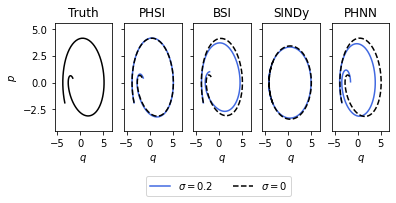

In [30]:
#trajectory comparison 
t_sim = np.linspace(0, 10, 101)
x0 = [-3.4, -1.9]
x_exact, dxdt, _, _ = pH_system.sample_trajectory(t_sim, x0)
x0 = x_exact[0]
nsamples = t_sim.shape[0]
x_phsi, _ = phsi.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_phnn, _ = phnn.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_baselinesi, _ = baselinesi.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_sindy = sindy.simulate(np.concatenate((x0, [0.])), t_sim)
x_phsi_noise, _ = phsi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_phnn_noise, _ = phnn_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_baselinesi_noise, _ = baselinesi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
x_sindy_noise = sindy_noise.simulate(np.concatenate((x0, [0.])), t_sim)

k=2; alpha=1
xmin = min(x_exact[:,0])
xmax = max(x_exact[:,0])
ymin = min(x_exact[:,1])
ymax = max(x_exact[:,1])
spacex = k*(xmax-xmin)/10
spacey = k*(ymax-ymin)/10
fig, ax = plt.subplots(1, 5)
c1 = "black"; c2 = "royalblue"
for i in range(4):
    ax[i+1].set_yticklabels([])    
fig.set_size_inches(6,2)
linewidth=1.5
for a in ax:
    a.set(xlim=(xmin-spacex, xmax+spacex), ylim=(ymin-spacey, ymax+spacey))
ax[0].plot(x_exact[:, 0], x_exact[:, 1], linewidth=linewidth, color=c1)
ax[1].plot(x_phsi_noise[:, 0], x_phsi_noise[:, 1], linewidth=linewidth, color=c2, alpha=alpha)
ax[1].plot(x_phsi[:, 0], x_phsi[:, 1], 'k--', linewidth=linewidth, color=c1)
ax[2].plot(x_baselinesi_noise[:, 0], x_baselinesi_noise[:, 1], linewidth=linewidth, color=c2, label='$\sigma = 0.2$', alpha=alpha)
ax[2].plot(x_baselinesi[:, 0], x_baselinesi[:, 1], 'k--', linewidth=linewidth, color=c1, label='$\sigma = 0$')
ax[3].plot(x_sindy_noise[:, 0], x_sindy_noise[:, 1], linewidth=linewidth, color=c2, alpha=alpha)
ax[3].plot(x_sindy[:, 0], x_sindy[:, 1], 'k--', linewidth=linewidth, color=c1)
ax[4].plot(x_phnn_noise[:, 0], x_phnn_noise[:, 1], linewidth=linewidth, color=c2, alpha=alpha)
ax[4].plot(x_phnn[:, 0], x_phnn[:, 1], 'k--', linewidth=linewidth, color=c1)
ax[2].legend(loc='center left', bbox_to_anchor=(-0.9,-0.5), ncol=2)
ax[0].set_ylabel('$p$')
for i in range(5):
    ax[i].set_xlabel('$q$')
ax[0].set_title('Truth')
ax[1].set_title('PHSI')
ax[2].set_title('BSI')
ax[3].set_title('SINDy')
ax[4].set_title('PHNN')
plt.savefig('plots/msd/msd_traj.pdf', bbox_inches='tight')
print(x0)


1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30


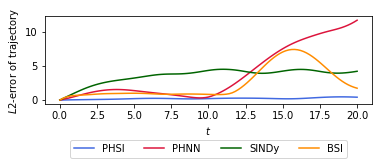

In [32]:
#position l2-error plot noise
t_sim = np.linspace(0, 20, 101)
nsamples = t_sim.shape[0]

sum_l2_phsi_noise = np.zeros((nsamples))
sum_l2_phnn_noise = np.zeros((nsamples))
sum_l2_sindy_noise = np.zeros((nsamples))
sum_l2_baselinesi_noise = np.zeros((nsamples))
c_phsi='royalblue'; c_baseline='darkorange'; c_sindy='darkgreen'; c_phnn='crimson'

nruns=30
for k in range(nruns):
    x_exact, dxdt, _, _ = pH_system.sample_trajectory(t_sim)
    x0 = x_exact[0, :]

    x_phsi_noise, _ = phsi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
    x_baselinesi_noise, _ = baselinesi_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)
    x_phnn_noise, _ = phnn_noise.simulate_trajectory(integrator=False, t_sample=t_sim, x0=x0)   
    x_sindy_noise = sindy_noise.simulate(np.concatenate((x0, [0.])), t_sim)[:,:2]

    x_exact = x_exact.reshape(-1, pH_system.nstates)
    x_phsi_noise = x_phsi_noise.reshape(-1, pH_system.nstates)
    x_baselinesi_noise = x_baselinesi_noise.reshape(-1, pH_system.nstates)

    sum_l2_phsi_noise += np.sqrt(np.sum((x_exact - x_phsi_noise)**2, axis=1))
    sum_l2_phnn_noise += np.sqrt(np.sum((x_exact - x_phnn_noise)**2, axis=1))
    sum_l2_sindy_noise += np.sqrt(np.sum((x_exact - x_sindy_noise)**2, axis=1))
    sum_l2_baselinesi_noise += np.sqrt(np.sum((x_exact - x_baselinesi_noise)**2, axis=1))
    print(f"{k+1} / {nruns}")

fig_l1, ax_l1 = plt.subplots()
fig_l1.set_size_inches(5.5, 2.5)
ax_l1.plot(t_sim, sum_l2_phsi_noise/nruns, color=c_phsi, label='PHSI')
ax_l1.plot(t_sim, sum_l2_phnn_noise/nruns, color=c_phnn, label='PHNN')
ax_l1.plot(t_sim, sum_l2_sindy_noise/nruns, color=c_sindy, label='SINDy')
ax_l1.plot(t_sim, sum_l2_baselinesi_noise/nruns, color=c_baseline, label='BSI')
ax_l1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35),
    fancybox=True, ncol=4)
ax_l1.set_ylabel('$L2$-error of trajectory')
ax_l1.set_xlabel('$t$')
fig_l1.tight_layout()
plt.savefig('plots/msd/msd_error_noise.pdf', bbox_inches='tight')